In [1]:
%load_ext ipycache
%load_ext autoreload
%autoreload 2

# from pyinstrument import Profiler

/opt/conda/lib/python3.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/opt/conda/lib/python3.7/site-packages/ipycache.py:17: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Unicode


# Initialization
## Hyperparameters for discovery

In [2]:
import sys
sys.path.insert(0, '../../../')
from src.discoverers.adsorption.values import calc_co2rr_activities


adsorbate = 'CO'
initial_training_size = 1000
batch_size = 200
quantile_cutoff = 0.9
target = -0.67  # eV

## Gather validation data

In [3]:
import random
from multiprocess import Pool
from tqdm import tqdm
import ase.db


db_dir = '../../pull_data/%s_synthesized/' % adsorbate
db = ase.db.connect(db_dir + '%s.db' % adsorbate)
rows = list(tqdm(db.select(), desc='reading ASE db', total=db.count()))
random.Random(42).shuffle(rows)



def parse_row(row):
    feature = row.id
    data = row.data
    label = data['adsorption_energy']
    surface = (data['mpid'], data['miller'], data['shift'], data['top'])
    return feature, label, surface
        
        
def parse_rows(rows): 
    with Pool(processes=32, maxtasksperchild=1000) as pool:
        iterator = pool.imap(parse_row, rows, chunksize=100)
        iterator_tracked = tqdm(iterator, desc='parsing rows', total=len(rows))
        parsed_rows = list(iterator_tracked)

    features, labels, surfaces = list(map(list, zip(*parsed_rows)))
    return features, labels, surfaces


# Data parsing
training_features, training_labels, training_surfaces = parse_rows(rows[:initial_training_size])
sampling_features, sampling_labels, sampling_surfaces = parse_rows(rows[initial_training_size:])

parsing rows: 100%|██████████| 420039/420039 [02:05<00:00, 3350.03it/s]


# Hallucinate
## Initialize

In [4]:
from src.discoverers.adsorption.models import NullModel


model = NullModel(db_dir, target)

In [5]:
from src.discoverers.adsorption.randomsearch import RandomSearcher


discoverer = RandomSearcher(model=model,
                                  quantile_cutoff=quantile_cutoff,
                                  value_calculator=calc_co2rr_activities,
                                  batch_size=batch_size,
                                  training_features=training_features,
                                  training_labels=training_labels,
                                  training_surfaces=training_surfaces,
                                  sampling_features=sampling_features,
                                  sampling_labels=sampling_labels,
                                  sampling_surfaces=sampling_surfaces,
                                  init_train=False  # Set to `False` only for warm starts
                                  )

## Run

In [6]:
# Or load the last run
discoverer.load_last_run()

## Analyze

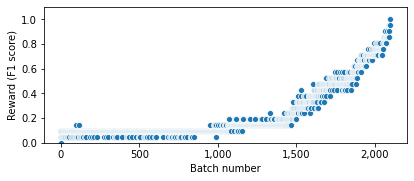

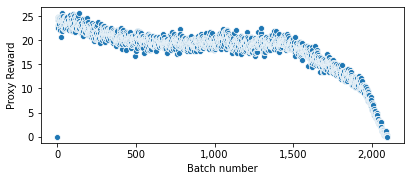

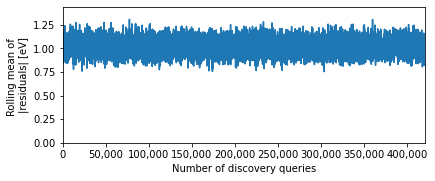

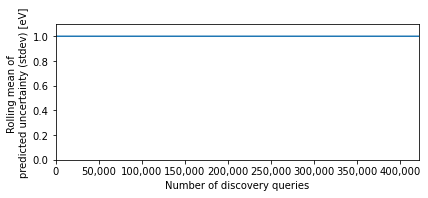

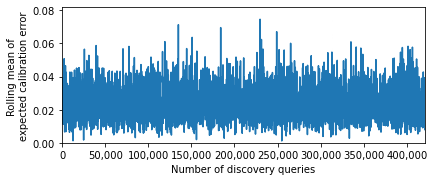

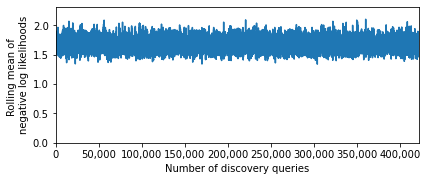

In [7]:
reward_fig, proxy_fig, accuracy_fig, uncertainty_fig, calibration_fig, nll_fig = discoverer.plot_performance(window=100)